In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import pandas as pd
from operator import sub, add
import glob
from random import shuffle
from itertools import product
from scipy import stats

In [2]:
home_path = os.path.expanduser('~') #need this to get correct home dir. across operating systems


exp_param_path = home_path + "/Documents/loki_1/experimental_parameters/reward_parameters_test/"
img_path = home_path + "/Documents/loki_1/images/symm_greebles/"

file_name = home_path+"/Documents/loki_1/experimental_parameters/training_greeble_images.csv"
training_set_images = pd.read_csv(file_name)

sample_itis = pd.read_csv(glob.glob(os.path.join(home_path,
                                          "Documents/loki_1/experimental_parameters/reward_parameters/*.csv")
                            )[0]).iti
os.chdir(exp_param_path)
os.getcwd()

'/Users/67981492/Documents/loki_1/experimental_parameters/reward_parameters_test'

In [3]:
n_trials = 300

In [4]:
def define_reward(opt_p, n_trials = 300, reward_mu=3, reward_std=1):

    trial_index = np.arange(n_trials)
    
    #define suboptimal choice reward probability
    subopt_p = 1 - opt_p

    #sample rewards
    reward_values = np.random.normal(loc=reward_mu, scale=reward_std, size=n_trials)

    #calcualte n_trials based on probabilities 
    n_opt_reward_trials = int(opt_p * n_trials)
    n_subopt_reward_trials = int(subopt_p * n_trials)

    #find indices for optimal and suboptimal choices 
    opt_reward_idx = np.random.choice(trial_index, size=n_opt_reward_trials, replace=False)
    subopt_reward_idx = np.setxor1d(trial_index, opt_reward_idx)

    #intialize reward vectors
    reward_t1, reward_t2 = np.zeros((n_trials)),np.zeros((n_trials))

    #assign rewards
    reward_t1[opt_reward_idx] = reward_values[opt_reward_idx] 
    reward_t2[subopt_reward_idx] = reward_values[subopt_reward_idx]
        
    return reward_t1, reward_t2

In [5]:
def define_changepoints(n_trials, reward_t1, reward_t2, cp_lambda):

    n_cps = int(n_trials/cp_lambda) #find approximate number of change points
    cp_base = np.cumsum(np.random.poisson(lam=cp_lambda,size=n_cps)) #calculate cp indices
    
    cp_idx = np.insert(cp_base,0,0) #add 0
    cp_idx = np.append(cp_idx,n_trials-1) #add 0

    cp_idx = cp_idx[cp_idx < n_trials] 
    
    cp_indicator = np.zeros(n_trials)
    cp_indicator[cp_idx] = 1
    
    return cp_idx, cp_indicator

In [6]:
def define_epochs(n_trials, reward_t1, reward_t2, cp_idx, opt_p):
    
    t1_epochs = []
    t2_epochs = []
    
    subopt_p = 1 - opt_p
    
    epoch_number = []
    epoch_trial = []
    epoch_length = []
    
    reward_p = []

    
    p_id_solution = [] #female greeble is always first 
    
    f_greeble = ord('f')
    m_greeble = ord('m')

    current_target = True
    for i in range(len(cp_idx)-1):
        if current_target: 
            t1_epochs.append(reward_t1[cp_idx[i]:cp_idx[i+1]])
            t2_epochs.append(reward_t2[cp_idx[i]:cp_idx[i+1]])
            reward_p.append(np.repeat(opt_p, cp_idx[i+1]-cp_idx[i]))
            p_id_solution.append(np.repeat(f_greeble, cp_idx[i+1]-cp_idx[i]))
        else: 
            t1_epochs.append(reward_t2[cp_idx[i]:cp_idx[i+1]])
            t2_epochs.append(reward_t1[cp_idx[i]:cp_idx[i+1]])
            reward_p.append(np.repeat(subopt_p, cp_idx[i+1]-cp_idx[i]))
            p_id_solution.append(np.repeat(m_greeble, cp_idx[i+1]-cp_idx[i]))
        
        epoch_number.append(np.repeat(i, cp_idx[i+1]-cp_idx[i]))
        epoch_trial.append(np.arange(cp_idx[i+1]-cp_idx[i]))
        epoch_length.append(np.repeat(len(np.arange(cp_idx[i+1]-cp_idx[i])),repeats=len(np.arange(cp_idx[i+1]-cp_idx[i]))))

        if i == len(cp_idx)-2:
            if current_target:
                t1_epochs.append(reward_t1[-1])
                t2_epochs.append(reward_t2[-1])
                reward_p.append(opt_p)
                p_id_solution.append(f_greeble)
            else:
                t1_epochs.append(reward_t2[-1])
                t2_epochs.append(reward_t1[-1])
                reward_p.append(opt_p)
                p_id_solution.append(m_greeble)

            epoch_number.append(i)
            
    

        current_target = not(current_target)
    
    epoch_length[-1] = epoch_length[-1] + 1
    #flatten    
    epoch_number = np.hstack(epoch_number).astype('float')
    epoch_trial = np.hstack(epoch_trial).astype('float')
    epoch_length = np.hstack(epoch_length).astype('float')
    
    epoch_trial = np.append(epoch_trial, (epoch_trial[-1] + 1))
    epoch_length = np.append(epoch_length, epoch_length[-1])

    t1_epochs = np.hstack(t1_epochs)
    t2_epochs = np.hstack(t2_epochs)
    reward_p = np.hstack(reward_p).astype('float')
    reward_p[-1] = reward_p[-2]
    p_id_solution = np.hstack(p_id_solution)

    return t1_epochs, t2_epochs, epoch_number, reward_p, p_id_solution, epoch_trial, epoch_length

In [7]:
def define_observed_cps(n_trials, t1_epochs):
    
    observed_cp_indicator = np.hstack([False, np.diff(t1_epochs == 0)]).astype('float')
    
    return observed_cp_indicator

In [8]:
def gen_itis(n_trials, iti_min=4, iti_max=16, rate_param=2.8):
        
   
    lower, upper, scale = iti_min, iti_max, rate_param
    X = stats.truncexpon(b=(upper-lower)/scale, loc=lower, scale=scale)
    itis = X.rvs(n_trials)

#     itis = np.random.permutation(np.repeat(sample_itis, n_trials // len(sample_itis)))

    return itis

In [9]:
subjects = np.arange(0,2)
n_runs = 5
initial_s_id = 811
# subject_ids = np.arange(initial_s_id, initial_s_id+len(subjects))
subject_ids = np.array([811, 860])


#here you would specify minimum and maximum probabilities, along with the increment 
min_p = 0.65
max_p = 0.95
step_p = 0.10

#Here you would specify the # trials before a switch in the optimal target identity 
min_e = 10
max_e  = 40
step_e = 10

conflict_means = np.arange(min_p, max_p, step_p)
vol_means = np.arange(min_e, max_e, step_e)

print(conflict_means, vol_means)

min_epoch_length = 4

conf_vol_combinations = np.round(list(product(conflict_means, vol_means)),2)

trials = np.arange(n_trials)

[0.65 0.75 0.85] [10 20 30]


In [10]:
conf_vol_combinations

array([[ 0.65, 10.  ],
       [ 0.65, 20.  ],
       [ 0.65, 30.  ],
       [ 0.75, 10.  ],
       [ 0.75, 20.  ],
       [ 0.75, 30.  ],
       [ 0.85, 10.  ],
       [ 0.85, 20.  ],
       [ 0.85, 30.  ]])

In [11]:
conf_vol_combinations[8]

array([ 0.85, 30.  ])

811
[ 0.65 10.  ]
[[8.603244283514424, 8.283529749189315, 8.31500486271605, 7.724702424436469, 8.435427823427222]]
811
[ 0.65 20.  ]
[[8.201913740028951, 8.088029006065375, 8.100892820350518, 8.298102446634262, 8.705631945518485]]
811
[ 0.65 30.  ]
[[8.377095280971421, 8.462531867574446, 8.063049917124953, 7.577891158807377, 7.5902136705452925]]
811
[ 0.75 10.  ]
[[8.383927809886792, 7.90609928071973, 8.07352728072543, 7.730539432654573, 8.473728031996798]]
811
[ 0.75 20.  ]
[[8.090676190588892, 7.916820194291742, 8.620025244352014, 8.35936196958337, 8.228818006960772]]
811
[ 0.75 30.  ]
[[7.815407597306039, 7.563633327134707, 8.009287835083907, 7.875864881943958, 8.214780883091713]]
811
[ 0.85 10.  ]
[[8.010523268171044, 7.974637869249561, 7.758479166548532, 8.196373416330239, 8.60014712882347]]
811
[ 0.85 20.  ]
[[7.403863352763577, 8.281354268245748, 8.013193466715665, 8.53304800167555, 8.610797252842103]]
811
[ 0.85 30.  ]
[[8.50210815525705, 8.021081506389187, 8.160208764829774, 7

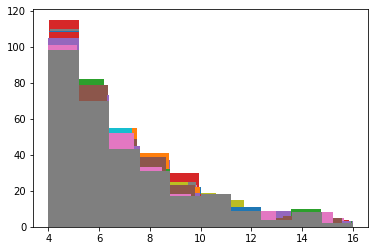

In [12]:
print_concat_df = False


for subject in subject_ids:
    for session_n,session in enumerate(conf_vol_combinations): 
        
        print(subject)
        print(session)

        
        opt_p=session[0]
        cp_lambda=session[1]
        
        min_epoch_length=0
        
        while min_epoch_length <=3: #need enough trials to analyze per epoch
        
            reward_t1, reward_t2 = define_reward(opt_p=opt_p, n_trials = 300, reward_mu=3, reward_std=1)
            cp_idx,cp_indicator = define_changepoints(n_trials, reward_t1, reward_t2, cp_lambda=cp_lambda)
            t1_epochs, t2_epochs, epoch_number,reward_p, p_id_solution, epoch_trial, epoch_length = define_epochs(n_trials, reward_t1, reward_t2, cp_idx, opt_p)
            observed_cp_indicator=define_observed_cps(n_trials, t1_epochs)
            itis = gen_itis(n_trials)
            
            min_epoch_length = min(epoch_length)
    
        filename = str(subject) + '_' + 'reward' + str(session_n) + '_' + 'cond' + str(int(opt_p*100)) + str(int(cp_lambda)) 
               
#         header = ('trial,r_t1,r_t2,cp,obs_cp,epoch_number,reward_p, m_image, f_image')
#         data = np.transpose(np.matrix((trials,t1_epochs, t2_epochs, cp_indicator, observed_cp_indicator, epoch_number, reward_p, training_set_images.m_image.values, training_set_images.f_image.values)))
#         np.savetxt(exp_param_path+filename, data, header=header, comments='',delimiter=',')

        header = ['trial','r_t0','r_t1','cp','obs_cp','epoch_number','reward_p_t0', 
                  'm_image', 'f_image', 'iti', 'p_id_solution', 'epoch_trial', 'epoch_length']

        
        # subset the training set images in case of varying n_trials
        training_set_images = training_set_images[:n_trials]
        
        #shuffle the order of the images
        np.random.shuffle(training_set_images.m_image.values)
        np.random.shuffle(training_set_images.f_image.values)

        data = pd.DataFrame(data=np.transpose(np.matrix((trials,t1_epochs, t2_epochs, cp_indicator, observed_cp_indicator, epoch_number, reward_p, training_set_images.m_image.values, training_set_images.f_image.values, itis, p_id_solution, epoch_trial, epoch_length))), columns=header)

        if print_concat_df: 
            data.to_csv(exp_param_path+filename + '.csv',index=False)
        
        #data split among runs 
        split_df = np.array_split(data, n_runs)
        
        [split_df[run].to_csv(exp_param_path+filename+'_run' + str(run+1) + '.csv', index=False)
         for run in range(len(split_df))]        
        
        n_trials_per_run = 60 
        run_time_max = 9 # run length is 9 m 20 s, but need buffer of 20 s (unexplained timing diff)
        
        run_times = []
        # check that the timing for each run is never > 9 m (buffer of 20 s)
        run_times.append([((df.iti.sum()) + (1.5 * n_trials_per_run)) / 60  for df in split_df])
        
        assert all(run_times) <= run_time_max, 'check run times'
        print(run_times)


        plt.hist(itis)
        

